# Лабораторная работа 1: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

#### Выполнение задания №1


##### Установили рекомендованную библиотеку через консольку

для этого воспользовались командой pip install

<img src="pip_cvxopt.png" width=750>

##### Пояснение к матрицам коэффициентов на бумажке

<img src="expl.jpg" width=750>

##### Сам код с использование установленной библиотеки

С его помощью мы находим решение задачи оптимизации

In [13]:
import numpy as np
from cvxopt import matrix, solvers

Q = matrix([[2.0, 0.0], [0.0, 8.0]])  # Квадратичная часть
p = matrix([[-8.0, -16.0]])               # Линейная часть


G = matrix([[1.0, -1.0, 0.0, 1.0],[1.0, 0.0, -1.0, 0.0]]) # Коэф-ты при иксах в левой части
h = matrix([5.0, 0.0, 0.0, 3.0])  # Правая часть ограничений

sol = solvers.qp(Q, p, G, h)

x = sol['x']
print("Оптимальное решение найдено:")
print(f"x1 = {x[0]:.4f}")
print(f"x2 = {x[1]:.4f}")

     pcost       dcost       gap    pres   dres
 0: -3.0512e+01 -3.8829e+01  8e+00  0e+00  2e-01
 1: -3.0792e+01 -3.1146e+01  4e-01  2e-16  5e-03
 2: -3.0982e+01 -3.1024e+01  4e-02  1e-16  4e-04
 3: -3.0997e+01 -3.1003e+01  6e-03  2e-16  5e-17
 4: -3.1000e+01 -3.1000e+01  7e-04  2e-16  1e-17
 5: -3.1000e+01 -3.1000e+01  1e-04  2e-16  4e-17
 6: -3.1000e+01 -3.1000e+01  1e-05  2e-16  3e-17
Optimal solution found.
Оптимальное решение найдено:
x1 = 3.0000
x2 = 1.9987


##### Ответ на вопрос к заданию

Заметим, что $$x_1=3$$тогда подставляя в первое ограничение, получаем  $$x_2 = 5 - 3 = 2$$В этом случае активными будут первое и второе ограничения: $$x_1 + x_2 \leq 5, \; $$

$$0 \leq x_1 \leq 3 \$$


## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

### Выполнение задания №2

#### 1. Сведение задачи обучения линейного SVM к QP

Обучение линейного SVM можно свести к задаче квадратичного программирования (QP). Основная идея заключается в минимизации функции min 1 / 2 ||w||²

при условии, что для всех i: yᵢ (wᵀ xᵢ + b) ≥ 1

где:

• w — вектор весов,

• b — смещение,

• xᵢ — вектор признаков,

• yᵢ — метка класса (1 или -1).

#### 2. Генерация случайных выборок

Используем библиотеку sklearn для генерации выборок.

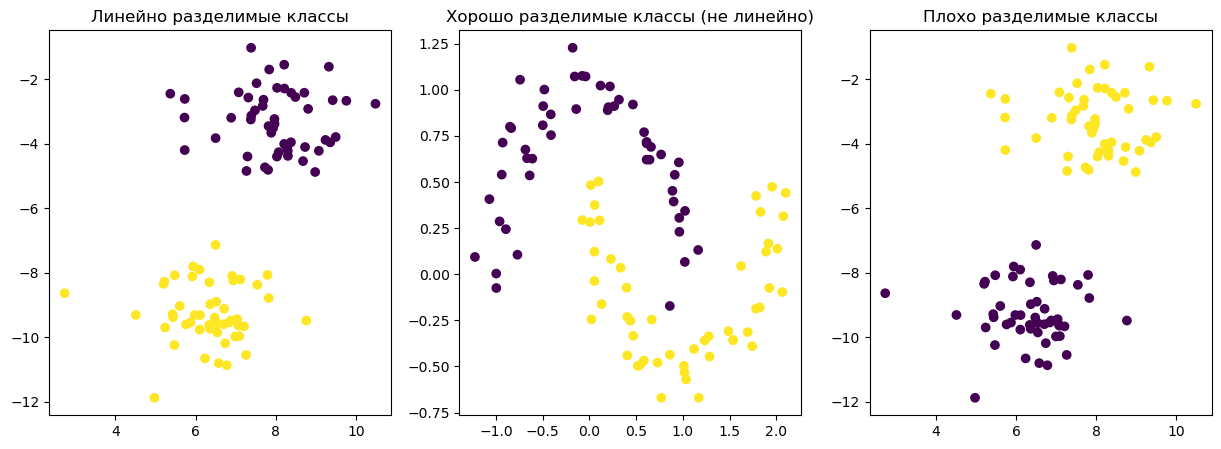

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles

# Линейно разделимые классы
X1, y1 = make_blobs(n_samples=100, centers=2, random_state=6)

# Хорошо разделимые, но не линейные классы
X2, y2 = make_moons(n_samples=100, noise=0.1, random_state=6)

# Плохо разделимые классы
X3, y3 = make_blobs(n_samples=100, centers=2, random_state=6)
y3 = np.where(X3[:, 0] + X3[:, 1] > 0, 1, -1)  # Переопределяем метки для плохой разделимости

# Визуализация выборок
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X1[:, 0], X1[:, 1], c=y1)
plt.title("Линейно разделимые классы")

plt.subplot(1, 3, 2)
plt.scatter(X2[:, 0], X2[:, 1], c=y2)
plt.title("Хорошо разделимые классы (не линейно)")

plt.subplot(1, 3, 3)
plt.scatter(X3[:, 0], X3[:, 1], c=y3)
plt.title("Плохо разделимые классы")

plt.show()

#### 3. Реализация линейного SVM с использованием QP-солвера

Используем cvxopt для решения задачи QP.

In [23]:
import numpy as np
from cvxopt import matrix, solvers

def svm_train(X, y, C):
    n_samples, n_features = X.shape
    
    # Создаем матрицы для QP
    K = np.dot(X, X.T) * np.outer(y, y)
    P = matrix(K)
    q = matrix(-np.ones(n_samples))
    
    # Ограничения
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), C * np.ones(n_samples))))
    
    A = matrix(y.reshape(1, -1), tc='d')
    b = matrix(0.0)
    
    # Решаем QP
    sol = solvers.qp(P, q, G, h, A=A, b=b)
    
    # Получаем альфа
    alphas = np.ravel(sol['x'])
    
    # Опорные векторы
    sv_indices = alphas > 1e-5
    if np.any(sv_indices):  # Проверяем, есть ли опорные векторы
        w = np.sum(alphas[sv_indices] * y[sv_indices][:, np.newaxis] * X[sv_indices], axis=0)
    else:
        raise ValueError("Нет опорных векторов. Проверьте данные.")
    
    # Вычисляем b
    b = np.mean(y[sv_indices] - np.dot(X[sv_indices], w))
    
    return w, b, alphas


# Обучение SVM на одной из выборок
C = 1.0
w, b, alphas = svm_train(X1, y1, C)


     pcost       dcost       gap    pres   dres
 0: -5.0000e+01 -1.5000e+02  4e+02  1e+00  3e-16
 1: -4.1599e+01 -8.0870e+01  4e+01  1e-02  4e-16
 2: -4.9111e+01 -5.0728e+01  2e+00  6e-04  5e-16
 3: -4.9991e+01 -5.0007e+01  2e-02  6e-06  5e-16
 4: -5.0000e+01 -5.0000e+01  2e-04  6e-08  3e-16
 5: -5.0000e+01 -5.0000e+01  2e-06  6e-10  4e-16
Optimal solution found.


ValueError: operands could not be broadcast together with shapes (50,50) (50,2) 

In [17]:
def plot_svm(X, y, w, b):
    plt.scatter(X[:, 0], X[:, 1], c=y)
    
    # Плоскость разделения
    xlim = plt.xlim()
    ylim = plt.ylim()
    
    xx = np.linspace(xlim[0], xlim[1])
    yy = np.linspace(ylim[0], ylim[1])
    YY, XX = np.meshgrid(yy, xx)
    
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = np.dot(xy, w) + b
    Z = Z.reshape(XX.shape)
    
    plt.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5)
    
    # Линии уровня f(x)=±1
    plt.contour(XX, YY, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles='dashed')

# Визуализируем SVM на линейно разделимых классах
plot_svm(X1, y1, w, b)
plt.title("SVM на линейно разделимых классах")
plt.show()


NameError: name 'w' is not defined

#### 4. Изучение зависимости числа опорных векторов от параметра C

В этом пункте мы задаем несколько вариантов значений С (в первой строке кода) и вычисляем количество опорных векторов в каждом случае.

In [18]:
C_values = [0.01, 0.1, 1.0, 10.0]
num_sv = []

for C in C_values:
    w, b, alphas = svm_train(X1, y1, C)
    num_sv.append(np.sum(alphas > 1e-5))

plt.plot(C_values, num_sv)
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Количество опорных векторов')
plt.title('Зависимость количества опорных векторов от C')
plt.show()


     pcost       dcost       gap    pres   dres
 0: -2.5250e+01 -1.7475e+00  4e+02  2e+01  3e-16
 1: -6.4866e-01 -1.7337e+00  6e+00  2e-01  8e-16
 2: -4.2370e-01 -1.0194e+00  6e-01  2e-03  4e-16
 3: -4.8724e-01 -5.1552e-01  3e-02  1e-04  3e-16
 4: -4.9987e-01 -5.0016e-01  3e-04  1e-06  3e-16
 5: -5.0000e-01 -5.0000e-01  3e-06  1e-08  4e-16
 6: -5.0000e-01 -5.0000e-01  3e-08  1e-10  1e-16
Optimal solution found.


ValueError: operands could not be broadcast together with shapes (50,50) (50,2) 

#### 5. Явное преобразование признаков и обучение SVM

Для этого пункта я использовала полиномиальные признаки

In [31]:
from sklearn.preprocessing import PolynomialFeatures

# Преобразуем признаки в полиномиальные
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X2)

# Обучаем SVM на полиномиальных признаках
C_poly = 1.0
w_poly, b_poly, alphas_poly = svm_train(X_poly, y2, C_poly)
# Визуализация полиномиальной разделяющей поверхности
def plot_polynomial_svm(X_poly, y):
    plt.scatter(X_poly[:, 1], X_poly[:, 2], c=y)  # Используем только первые два полинома
    
    # Плоскость разделения
    xlim = plt.xlim()
    ylim = plt.ylim()
    
    xx = np.linspace(xlim[0], xlim[1])
    yy = np.linspace(ylim[0], ylim[1])
    
    Z = np.zeros((len(xx), len(yy)))
    
    for i in range(len(xx)):
        for j in range(len(yy)):
            Z[i][j] = np.dot(np.array([1, xx[i], yy[j]]), w_poly) + b_poly
            
    plt.contourf(xx, yy, Z.T > 0, alpha=0.5)

plot_polynomial_svm(X_poly, y2)
plt.title("Полиномиальная SVM")
plt.show()


     pcost       dcost       gap    pres   dres
 0: -5.0000e+01 -1.5000e+02  4e+02  1e+00  2e-16
 1: -4.1599e+01 -8.0870e+01  4e+01  1e-02  4e-16
 2: -4.9111e+01 -5.0728e+01  2e+00  6e-04  4e-16
 3: -4.9991e+01 -5.0007e+01  2e-02  6e-06  4e-16
 4: -5.0000e+01 -5.0000e+01  2e-04  6e-08  3e-16
 5: -5.0000e+01 -5.0000e+01  2e-06  6e-10  5e-16
Optimal solution found.


ValueError: operands could not be broadcast together with shapes (50,50) (50,6) 

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

### Выполнение задания №3

#### Шаг 1-2: Реализация ядрового SVM

В этом пункте мы описываем функцию kernel (ядро) с помощью которой реализуем процедуру обучения ядрового SVM и визуализируем результаты тестирования  (во второй ячейке). а:

In [25]:
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

def kernel(X1, X2, kernel_type='linear', p=3, gamma=1.0):
    if kernel_type == 'linear':
        return np.dot(X1, X2.T)
    elif kernel_type == 'polynomial':
        return (np.dot(X1, X2.T) + 1) ** p
    elif kernel_type == 'rbf':
        sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return np.exp(-sq_dists / (2 * gamma))
    else:
        raise ValueError("Unknown kernel type")

def svm_train(X, y, C, kernel_type='linear', p=3, gamma=1.0):
    n_samples, n_features = X.shape
    K = kernel(X, X, kernel_type, p, gamma)

    P = matrix(K * np.outer(y, y), tc='d')
    q = matrix(-np.ones(n_samples))
    
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))), tc='d')
    h = matrix(np.hstack((np.zeros(n_samples), C * np.ones(n_samples))), tc='d')
    
    A = matrix(y.reshape(1, -1), tc='d')
    b = matrix(0.0)
    
    sol = solvers.qp(P, q, G, h, A=A, b=b)
    
    alphas = np.ravel(sol['x'])
    
    sv_indices = alphas > 1e-5
    w = np.sum(alphas[sv_indices] * y[sv_indices][:, np.newaxis] * X[sv_indices], axis=0) if np.any(sv_indices) else None
    
    b = np.mean(y[sv_indices] - np.dot(X[sv_indices], w)) if w is not None else None
    
    return w, b, alphas

def predict(X, w, b, kernel_type='linear', X_train=None, alphas=None):
    if kernel_type == 'linear':
        return np.sign(np.dot(X, w) + b)
    else:
        K = kernel(X_train, X, kernel_type)
        return np.sign(np.dot(K.T, alphas * y) + b)

# Генерация случайных данных
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, centers=2, random_state=6)
y[y == 0] = -1  # Приводим метки к {-1, 1}


     pcost       dcost       gap    pres   dres
 0: -8.1834e+00 -1.8539e+02  1e+03  3e+00  8e-14
 1: -4.2642e+00 -9.3491e+01  2e+02  3e-01  5e-14
 2: -6.2937e-01 -1.1948e+01  2e+01  3e-02  3e-14
 3:  5.5505e-02 -9.3045e-01  1e+00  3e-04  1e-14
 4: -1.5149e-01 -4.4112e-01  3e-01  9e-05  4e-15
 5: -2.5673e-01 -4.3934e-01  2e-01  3e-05  6e-15
 6: -3.3924e-01 -3.4542e-01  6e-03  8e-07  1e-14
 7: -3.4163e-01 -3.4169e-01  6e-05  8e-09  1e-14
 8: -3.4165e-01 -3.4165e-01  6e-07  8e-11  1e-14
 9: -3.4165e-01 -3.4165e-01  6e-09  8e-13  9e-15
Optimal solution found.


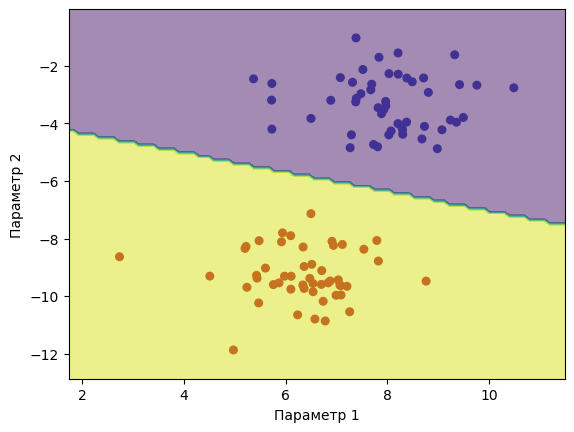

     pcost       dcost       gap    pres   dres
 0: -2.3953e+00 -1.1563e+02  5e+02  2e+00  7e-10
 1: -1.3236e+00 -3.8784e+01  6e+01  1e-01  4e-10
 2: -2.8412e-01 -7.3603e+00  1e+01  2e-02  3e-10
 3: -1.1035e-02 -3.5918e-01  5e-01  8e-04  6e-11
 4: -5.1016e-03 -1.5587e-01  2e-01  3e-04  2e-11
 5: -1.7676e-03 -6.4034e-02  9e-02  1e-04  7e-12
 6: -2.6510e-04 -7.8952e-03  1e-02  1e-05  9e-13
 7: -4.9142e-06 -7.9807e-04  1e-03  9e-07  9e-14
 8:  3.4213e-06 -3.1385e-05  4e-05  9e-09  4e-15
 9: -3.7303e-06 -1.6514e-05  1e-05  3e-09  2e-15
10: -6.2485e-06 -1.8387e-05  1e-05  2e-09  3e-15
11: -1.1749e-05 -1.2972e-05  1e-06  2e-10  4e-15
12: -1.2396e-05 -1.2423e-05  3e-08  3e-12  4e-15
Optimal solution found.


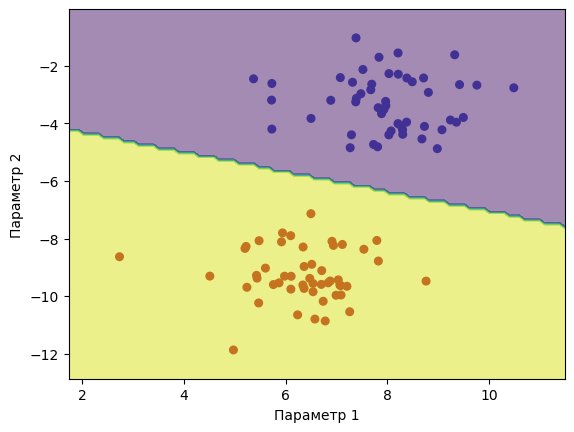

In [28]:
def plot_decision_boundary(X, y, w, b):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30)
    
    # Создаем сетку для предсказания
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    # Предсказание на сетке
    Z = predict(np.c_[xx.ravel(), yy.ravel()], w, b)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.5)
    

    plt.xlabel('Параметр 1')
    plt.ylabel('Параметр 2')
    plt.show()

# Обучение модели и визуализация
C = 1.0
kernel_type = 'linear' 
w, b, alphas = svm_train(X, y, C, kernel_type)

plot_decision_boundary(X, y, w, b)

C = 1.0
kernel_type = 'polynomial' 

w, b, alphas = svm_train(X, y, C, kernel_type)

plot_decision_boundary(X, y, w, b)

#### Шаг 3: Изучение влияния параметров

Варьируем параметры C и p для полиномиального ядра и C и γ для RBF-ядра. Чтобы это сделать я создаю цикл по значениям этих параметров, после этого визуализируем результаты.

     pcost       dcost       gap    pres   dres
 0: -4.1438e+00 -1.4750e+00  4e+02  2e+01  5e-12
 1: -1.5755e-01 -1.4528e+00  8e+00  4e-01  5e-12
 2: -6.9601e-02 -8.8758e-01  2e+00  5e-02  7e-13
 3: -2.4858e-02 -2.1506e-01  3e-01  9e-03  2e-13
 4: -8.2371e-03 -5.0377e-02  7e-02  2e-03  4e-14
 5: -7.3626e-04 -1.9597e-02  3e-02  5e-04  2e-14
 6: -8.1867e-04 -5.2420e-03  6e-03  1e-04  4e-15
 7: -6.9107e-04 -3.3557e-03  3e-03  2e-17  3e-15
 8: -1.6889e-03 -2.0063e-03  3e-04  2e-17  4e-15
 9: -1.7712e-03 -1.7757e-03  4e-06  2e-17  5e-15
10: -1.7726e-03 -1.7726e-03  4e-08  2e-17  5e-15
Optimal solution found.


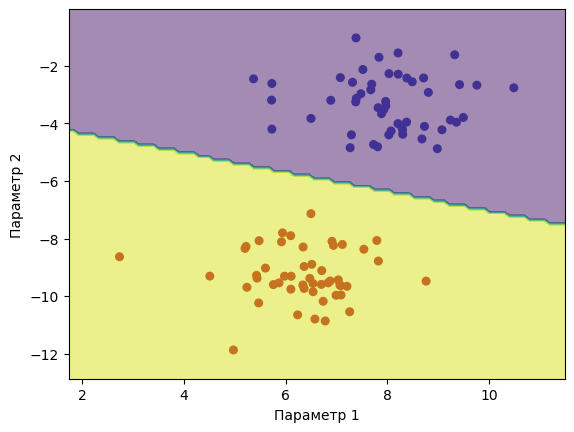

     pcost       dcost       gap    pres   dres
 0: -4.5114e+00 -1.5016e+01  4e+02  2e+01  5e-12
 1: -8.8000e-01 -1.3377e+01  4e+01  1e+00  5e-12
 2: -4.0176e-01 -4.8982e+00  7e+00  2e-01  9e-13
 3: -1.0364e-01 -1.0616e+00  1e+00  3e-02  5e-13
 4: -4.0776e-02 -4.4954e-01  6e-01  1e-02  2e-13
 5: -1.2860e-03 -2.7455e-02  4e-02  6e-04  7e-14
 6: -6.6297e-04 -2.1421e-03  2e-03  6e-06  4e-15
 7: -1.1490e-03 -2.3347e-03  1e-03  3e-06  4e-15
 8: -1.7266e-03 -1.8026e-03  8e-05  2e-07  4e-15
 9: -1.7720e-03 -1.7729e-03  1e-06  2e-09  5e-15
10: -1.7726e-03 -1.7726e-03  1e-08  2e-11  5e-15
Optimal solution found.


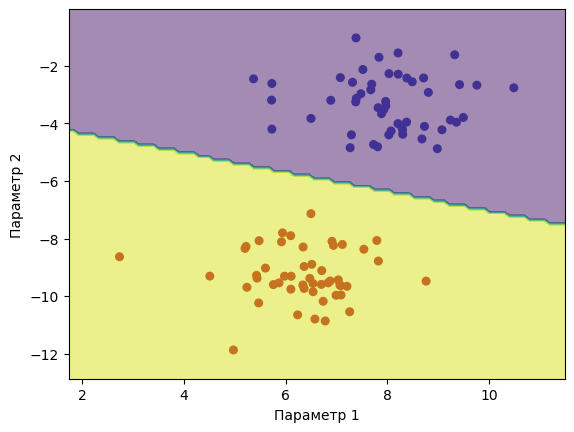

     pcost       dcost       gap    pres   dres
 0: -8.1740e+00 -1.9091e+02  1e+03  3e+00  1e-11
 1: -4.3858e+00 -9.8924e+01  2e+02  3e-01  5e-12
 2: -1.1629e+00 -1.5992e+01  3e+01  4e-02  5e-12
 3: -1.6274e-01 -2.5280e+00  4e+00  6e-03  2e-12
 4: -4.2155e-03 -8.6782e-02  1e-01  2e-04  2e-13
 5:  3.8388e-04 -4.4550e-03  5e-03  2e-06  1e-14
 6: -7.2423e-04 -2.1545e-03  1e-03  5e-07  4e-15
 7: -1.1301e-03 -2.3282e-03  1e-03  3e-07  3e-15
 8: -1.7302e-03 -1.8171e-03  9e-05  2e-08  5e-15
 9: -1.7719e-03 -1.7732e-03  1e-06  2e-10  6e-15
10: -1.7726e-03 -1.7726e-03  1e-08  2e-12  5e-15
Optimal solution found.


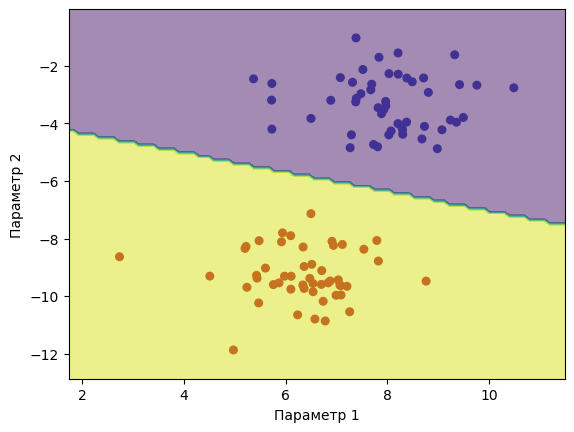

     pcost       dcost       gap    pres   dres
 0: -1.2168e+00 -1.3046e+00  3e+02  2e+01  4e-10
 1: -4.0991e-02 -1.2810e+00  5e+00  2e-01  3e-10
 2: -2.3286e-02 -5.6376e-01  8e-01  2e-02  3e-11
 3: -6.5896e-03 -1.3487e-01  2e-01  4e-03  7e-12
 4: -2.9330e-03 -7.2315e-02  1e-01  2e-03  3e-12
 5: -6.2980e-04 -7.9348e-03  1e-02  2e-04  8e-13
 6: -6.4697e-05 -8.1634e-04  1e-03  2e-05  1e-13
 7: -4.9521e-06 -1.0890e-04  1e-04  1e-06  2e-14
 8: -6.7681e-06 -3.9146e-05  4e-05  4e-07  5e-15
 9: -4.8930e-06 -2.5143e-05  2e-05  7e-09  4e-15
10: -1.1984e-05 -1.3221e-05  1e-06  1e-10  4e-15
11: -1.2401e-05 -1.2431e-05  3e-08  2e-12  4e-15
Optimal solution found.


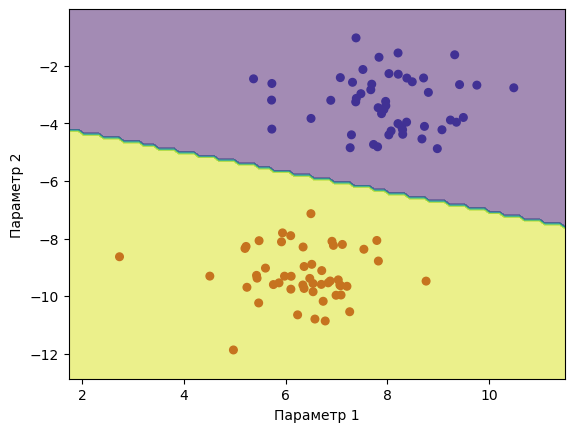

     pcost       dcost       gap    pres   dres
 0: -1.3245e+00 -1.2355e+01  3e+02  2e+01  4e-10
 1: -2.3997e-01 -1.0630e+01  2e+01  3e-01  3e-10
 2: -1.0192e-01 -2.7739e+00  4e+00  7e-02  8e-11
 3: -2.4351e-02 -6.6582e-01  9e-01  2e-02  3e-11
 4: -5.3601e-03 -1.1560e-01  1e-01  3e-03  7e-12
 5: -2.2670e-03 -6.5787e-02  9e-02  1e-03  3e-12
 6: -3.2480e-04 -5.0167e-03  7e-03  9e-05  5e-13
 7: -4.0283e-05 -7.6360e-04  1e-03  1e-05  1e-13
 8: -2.8449e-06 -3.3527e-05  3e-05  2e-07  9e-15
 9: -6.4756e-06 -1.9955e-05  1e-05  9e-08  4e-15
10: -9.0523e-06 -1.8059e-05  9e-06  1e-08  3e-15
11: -1.2224e-05 -1.2718e-05  5e-07  6e-10  3e-15
12: -1.2408e-05 -1.2418e-05  1e-08  1e-11  4e-15
Optimal solution found.


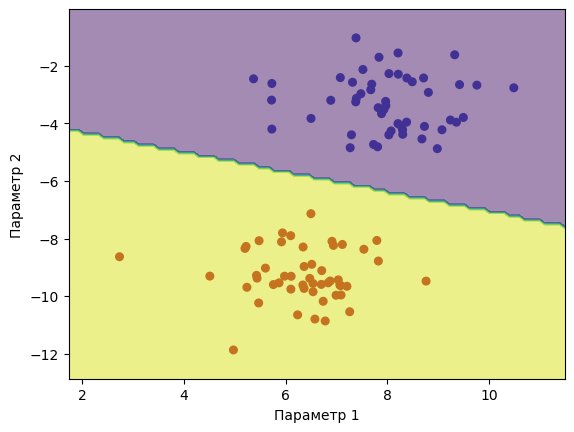

     pcost       dcost       gap    pres   dres
 0: -2.3953e+00 -1.1563e+02  5e+02  2e+00  7e-10
 1: -1.3236e+00 -3.8784e+01  6e+01  1e-01  4e-10
 2: -2.8412e-01 -7.3603e+00  1e+01  2e-02  3e-10
 3: -1.1035e-02 -3.5918e-01  5e-01  8e-04  6e-11
 4: -5.1016e-03 -1.5587e-01  2e-01  3e-04  2e-11
 5: -1.7676e-03 -6.4034e-02  9e-02  1e-04  7e-12
 6: -2.6510e-04 -7.8952e-03  1e-02  1e-05  9e-13
 7: -4.9142e-06 -7.9807e-04  1e-03  9e-07  9e-14
 8:  3.4213e-06 -3.1385e-05  4e-05  9e-09  4e-15
 9: -3.7303e-06 -1.6514e-05  1e-05  3e-09  2e-15
10: -6.2485e-06 -1.8387e-05  1e-05  2e-09  3e-15
11: -1.1749e-05 -1.2972e-05  1e-06  2e-10  4e-15
12: -1.2396e-05 -1.2423e-05  3e-08  3e-12  4e-15
Optimal solution found.


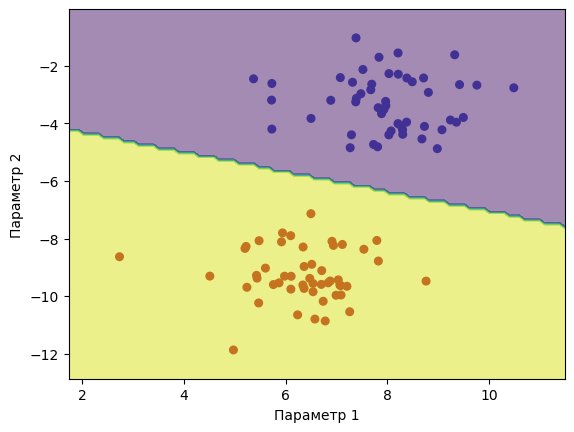

     pcost       dcost       gap    pres   dres
 0: -1.0260e+00 -1.2554e+00  3e+02  2e+01  2e-08
 1: -3.0771e-02 -1.2359e+00  5e+00  2e-01  2e-08
 2: -1.6189e-02 -5.0085e-01  7e-01  1e-02  2e-09
 3: -3.7187e-03 -8.9907e-02  1e-01  2e-03  4e-10
 4: -7.2938e-05 -1.0485e-02  1e-02  2e-04  1e-10
 5: -1.1773e-05 -1.3299e-03  2e-03  3e-05  1e-11
 6: -1.5058e-05 -6.4551e-04  8e-04  1e-05  6e-12
 7: -1.1642e-05 -2.3083e-04  3e-04  3e-06  2e-12
 8: -1.0225e-06 -1.3693e-05  2e-05  2e-07  2e-13
 9: -7.9621e-08 -1.3163e-06  2e-06  1e-08  2e-14
10: -5.6110e-08 -3.1496e-07  3e-07  3e-09  6e-15
11: -6.4464e-08 -3.1585e-07  3e-07  2e-09  5e-15
12: -8.9422e-08 -1.4058e-07  6e-08  4e-10  2e-15
Optimal solution found.


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

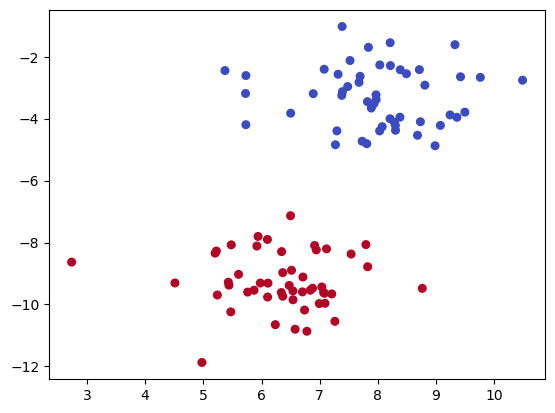

In [30]:
# Для полиномиального ядра
for p in range(2, 5):
    for C in [0.01, 0.1, 1.0]:
        w, b, alphas = svm_train(X, y, C=C, kernel_type='polynomial', p=p)
        plot_decision_boundary(X, y, w, b)

# Для RBF-ядра
for gamma in [0.01, 0.1, 1.0]:
    for C in [0.01, 0.1, 1.0]:
        w, b, alphas = svm_train(X, y, C=C, kernel_type='rbf', gamma=gamma)
        plot_decision_boundary(X, y, w, b)


# Примеры

Настройка вывода графиков [`Maplotlib`](http://matplotlib.org/) и импорт функций из модуля [`pylab`](http://wiki.scipy.org/PyLab).

In [22]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['matrix']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Визуальное решение задачи квадратичного программирования

На следующем рисунке наглядно показано решение задачи QP из задания 1. Оптимизируемая функция $f(\boldsymbol x)$ показана линиями уровня, область значений недопустимых ограничениями окрашена в серый цвет.

C:\Anaconda3\lib\site-packages\matplotlib\contour.py:902: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


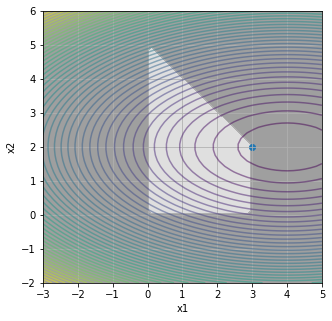

In [33]:
x1 = linspace(-3, 5, 50)
x2 = linspace(-2, 6, 50)
xx1, xx2 = meshgrid(x1, x2)

f = -8*xx1 - 16*xx2 + xx1**2 + 4*xx2**2
constr1 = (xx1 + xx2 <= 5)
constr2 = (0 <= xx1) & (xx1 <= 3)
constr3 = (xx2 >= 0)

figure(figsize=(5, 5))
grid(True)
xlabel('x1')
ylabel('x2')

contour(x1, x2, f, 50, alpha=0.5)
contourf(x1, x2, constr1 & constr2 & constr3, 1, alpha=0.5, linewidths=4, cmap='gray')
_ = scatter([3], [2])

In [26]:
np.array([True, False, False]) & np.array([True, False, True])

array([ True, False, False])

In [27]:
np.logical_and(np.array([True, False, False]), np.array([True, False, True]))

array([ True, False, False])

## Установка и использование `CvxOpt`

Библиотека [`cvxopt`](http://cvxopt.org/) может быть установлена как обычный python-пакет:

In [5]:
!pip install --upgrade --user cvxopt

  Using cached https://files.pythonhosted.org/packages/16/a0/0d090735e2639a74d6628831e02cc59284e3a3a4f5910f496fc6e435b645/cvxopt-1.2.5-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/56/39/537cb3e4e93f1ac5085dc3b3a43cfd99d0af9b29c44fcaa99490f526b611/mkl-2019.0-py2.py3-none-win_amd64.whl


Нас будет интересовать функция [`cvxopt.solvers.qp()`](http://cvxopt.org/examples/tutorial/qp.html):

In [6]:
from cvxopt import solvers
?solvers.qp

## Пример работы с cvxopt

In [4]:
from cvxopt import matrix

A = matrix([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], (2,3))
print(A)
print(A.size)

[ 1.00e+00  3.00e+00  5.00e+00]
[ 2.00e+00  4.00e+00  6.00e+00]

(2, 3)


In [6]:
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],
            [0.0,-1.0,-3.0,5.0,4.0]])
print(G, G.size)

[-1.00e+00  0.00e+00]
[ 0.00e+00 -1.00e+00]
[-1.00e+00 -3.00e+00]
[ 2.00e+00  5.00e+00]
[ 3.00e+00  4.00e+00]
 (5, 2)


In [13]:
from cvxopt import solvers

# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])
# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
print(sol['x']) # [7.13e-07, 5.00e+00]
print(sol['primal objective']) # 20.0000061731

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  4e-17  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  8e-17  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  8e-17  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  7e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  1e-16  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  9e-17  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  7e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  8e-17  2e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  2e-16
Optimal solution found.
[ 7.13e-07]
[ 5.00e+00]

20.00000617311241


In [14]:
sol

{'x': <2x1 matrix, tc='d'>,
 'y': <0x1 matrix, tc='d'>,
 's': <5x1 matrix, tc='d'>,
 'z': <5x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 8.788553731701274e-06,
 'relative gap': 4.3942774404993765e-07,
 'primal objective': 20.00000617311241,
 'dual objective': 19.99999738455868,
 'primal infeasibility': 1.1710307819972547e-16,
 'dual infeasibility': 1.9860273225978186e-16,
 'primal slack': 7.131816408857108e-07,
 'dual slack': 1.50695110360481e-08,
 'iterations': 8}

In [19]:
print(sol['x'])

[ 7.13e-07]
[ 5.00e+00]



Матрицы задач квадратичного программирования как правило разрежены, лучше использовать матричные операции над разреженными матрицами при реализации SVM.
[Разреженные и плотные матрицы](http://abel.ee.ucla.edu/cvxopt/userguide/matrices.html)

## Генерация случайной выборки для задачи классификации

В `SciKit-Learn` есть функция генерации случайных выборок для классификации [`sklearn.datasets.make_classification()`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Для того чтобы выборки не менялись при перезапуске ноутбука, используйте параметр `random_state`.

In [7]:
from sklearn.datasets import make_classification

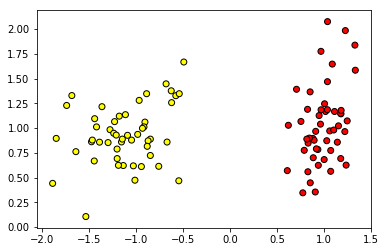

In [10]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

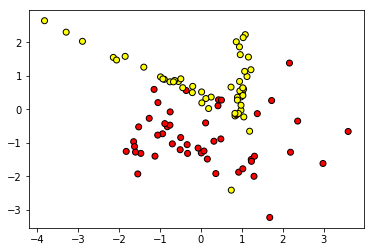

In [11]:
X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=2, random_state=2)
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolor='black')

## Визуализация решающего правила

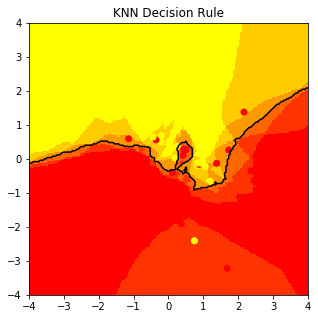

In [12]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

figure(figsize=(5, 5))
scatter(X[:, 0], X[:, 1], c=y, cmap='autumn')

xvals = linspace(-4, 4, 200)
yvals = linspace(-4, 4, 200)

xx, yy = np.meshgrid(xvals, yvals)
zz = np.reshape(model.predict_proba(c_[xx.ravel(), yy.ravel()])[:, 1], xx.shape)

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx, yy, zz, levels=(0.5,), colors='k', linewidths=1.5, zorder=1)

xlim([-4, 4])
ylim([-4, 4])
_ = title('KNN Decision Rule')

## Реализация собственной модели для SciKit-Learn

В заданиях 2 и 3 требуется самостоятельно реализовать алгоритм обучения классификатора. Для того чтобы ваш алгоритм можно было использовать различными компонентами библиотеки SciKit-Learn (оценка качества, подбор параметров, композиции и т.д.) нужно всего лишь [реализовать интерфейс `BaseEstimator`](http://scikit-learn.org/stable/developers/#estimators).

In [13]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        dim = X.shape[1]
        self.weights_ = empty(dim)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        return (dot(X, self.weights_) + self.bias_).flatten()
            
    def predict(self, X):
        return sign(self.predict_proba(X))

In [ ]:
from sklearn.base import BaseEstimator

class DualSVM(BaseEstimator):
    def __init__(self, C, kernel=None):
        self.C = C
        self.kernel = kernel
        
    def fit(self, X, y):
        """
        Функция обучения модели.
        """
        self.dim = X.shape[1]
        self.N = X.shape[0]
        self.alpha_ = empty(self.N)
        self.bias_ = 0
        raise NotImplementedError() 
        
    def predict_proba(self, X):
        pass
            
    def predict(self, X):
        pass